<a id='top'></a>
# Customer churn.
## Are customers still with us?

#### We'd better find out what's going on.

1. [Project description](#1)
2. [Data Preprocessing](#2)
3. [Exploratory data analysis](#3)
4. [Building a model to predict user churn](#4)
5. [Creating user clusters](#5)
6. [Conclusion.](#6)

## 1. Project description <a id='1'></a>
[Back to top](#top)

### The gym chain: "Model Fitness"
#### The problem: customer churn.
#### Tasks:
* Predict the probability of churn (for the upcoming month) for each customer
* Analyze the factors that impact churn most
* Draw up typical user portraits: 
    * select the most outstanding groups 
    * describe their main features

## 2. Data Preprocessing <a id='2'></a>
[Back to top](#top)

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage

from sklearn.inspection import permutation_importance 
from sklearn.metrics import accuracy_score, precision_score, recall_score

In [2]:
gym_churn = pd.read_csv('gym_churn_us.csv')

The dataset includes the following fields:
* `'Churn'` — the fact of churn for the month in question

Current dataset fields:

User data for the preceding month
* `'gender'`
* `'Near_Location'` — whether the user lives or works in the neighborhood where the gym is located
* `'Partner'` — whether the user is an employee of a partner company (the gym has partner companies whose employees get discounts; in those cases the gym stores information on customers' employers)
* `'Promo_friends'` — whether the user originally signed up through a "bring a
friend" offer (they used a friend's promo code when paying for their first
membership)
* `'Phone'` — whether the user provided their phone number
* `'Age'`
* `'Lifetime'` — the time (in months) since the customer first came to the gym

Data from the log of visits and purchases and data on current membership status
* `'Contract_period'` — 1 month, 3 months, 6 months, or 1 year
* `'Month_to_end_contract'` — the months remaining until the contract expires
* `'Group_visits'` — whether the user takes part in group sessions
* `'Avg_class_frequency_total'` — average frequency of visits per week over the

In [3]:
gym_churn.head()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


In [4]:
# general information
gym_churn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

In [5]:
gym_churn.isna().sum()

gender                               0
Near_Location                        0
Partner                              0
Promo_friends                        0
Phone                                0
Contract_period                      0
Group_visits                         0
Age                                  0
Avg_additional_charges_total         0
Month_to_end_contract                0
Lifetime                             0
Avg_class_frequency_total            0
Avg_class_frequency_current_month    0
Churn                                0
dtype: int64

In [6]:
gym_churn.duplicated().sum()

0

#### We checked:
* data types
* missing values
* duplicates

## 3. Exploratory data analysis <a id='3'></a>
[Back to top](#top)

In [7]:
# basic statistics
gym_churn.describe()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,0.510250,0.845250,0.486750,0.308500,0.903500,4.681250,0.412250,29.184250,146.943728,4.322750,3.724750,1.879020,1.767052,0.265250
std,0.499957,0.361711,0.499887,0.461932,0.295313,4.549706,0.492301,3.258367,96.355602,4.191297,3.749267,0.972245,1.052906,0.441521
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,18.000000,0.148205,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,27.000000,68.868830,1.000000,1.000000,1.180875,0.963003,0.000000
50%,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,29.000000,136.220159,1.000000,3.000000,1.832768,1.719574,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000,1.000000,31.000000,210.949625,6.000000,5.000000,2.536078,2.510336,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,12.000000,1.000000,41.000000,552.590740,12.000000,31.000000,6.023668,6.146783,1.000000



From the table above we can get a general idea of the average customer of the gym
<br>

An average customer:    
    
* man or woman 29 years old
* generaly lives nearby
* provides his/her phone number
* visits the gym about twice a week
* loyal (no intentions to leave)
* remains a customer for at least 3 months
* has the 'Contract_period' between 3 and 6 months
* shows moderate activity


In [8]:
# gym_churn.groupby('Churn').mean()

#### The mean and median values by churn 
Two groups:
* those who stayed = 0
* those who left = 1

In [9]:
gym_churn.groupby('Churn').agg(['median','mean']).T

Churn                                              0           1
gender                            median    1.000000    1.000000
                                  mean      0.510037    0.510839
Near_Location                     median    1.000000    1.000000
                                  mean      0.873086    0.768143
Partner                           median    1.000000    0.000000
                                  mean      0.534195    0.355325
Promo_friends                     median    0.000000    0.000000
                                  mean      0.353522    0.183789
Phone                             median    1.000000    1.000000
                                  mean      0.903709    0.902922
Contract_period                   median    6.000000    1.000000
                                  mean      5.747193    1.728558
Group_visits                      median    0.000000    0.000000
                                  mean      0.464103    0.268615
Age                               median   30.000000   27.000000
                                  mean     29.976523   26.989632
Avg_additional_charges_total      median  149.881171  103.814686
                                  mean    158.445715  115.082899
Month_to_end_contract             median    6.000000    1.000000
                                  mean      5.283089    1.662582
Lifetime                          median    4.000000    1.000000
                                  mean      4.711807    0.990575
Avg_class_frequency_total         median    2.043252    1.491187
                                  mean      2.024876    1.474995
Avg_class_frequency_current_month median    2.046697    0.979445
                                  mean      2.027882    1.044546

#### Feature distributions by churn 
* group 'stayed' = 0
* group 'left' = 1

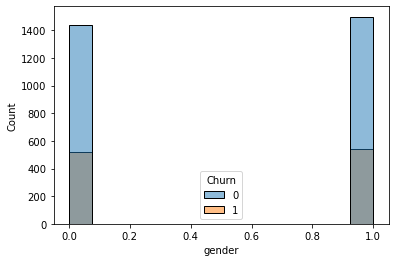

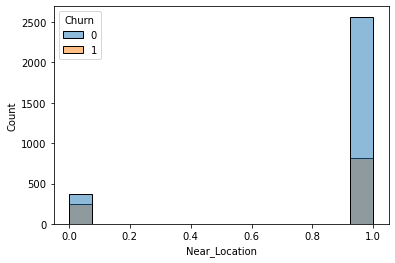

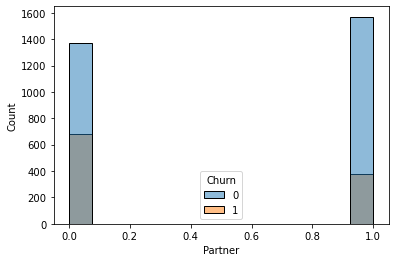

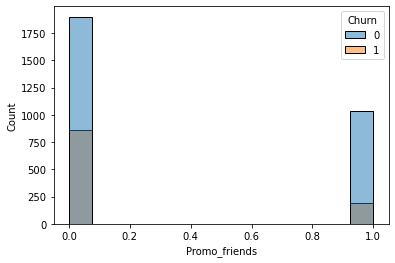

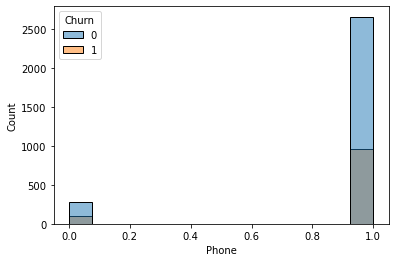

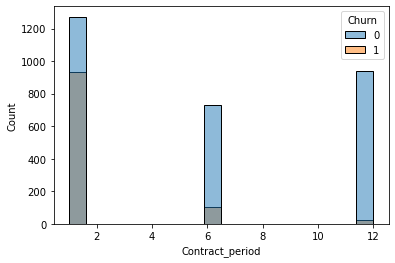

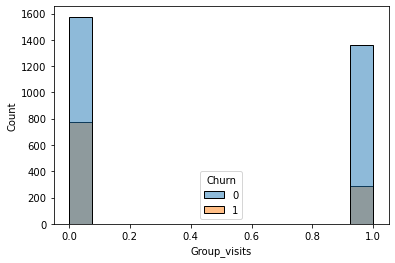

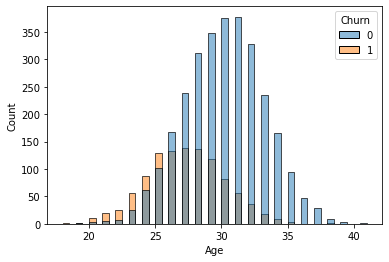

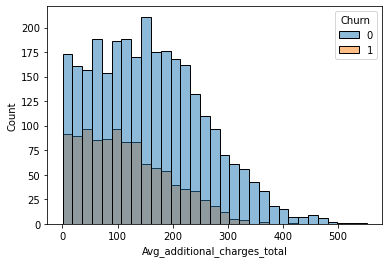

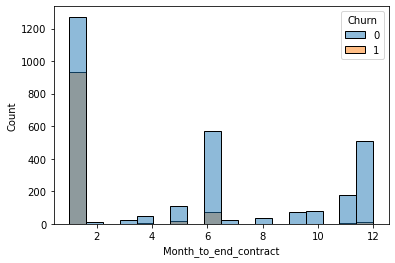

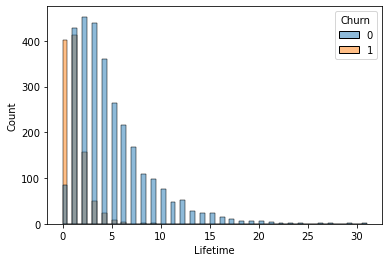

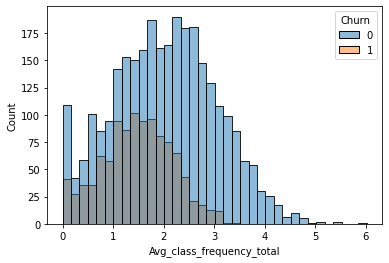

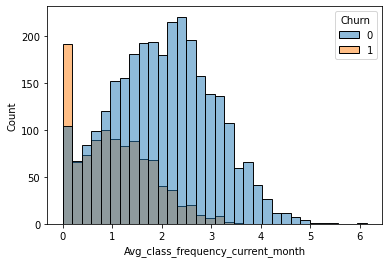

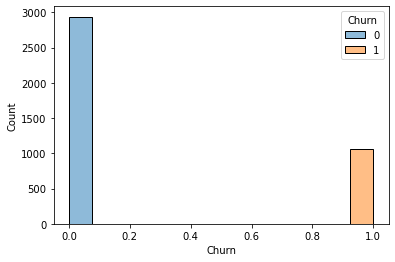

In [10]:
for col in gym_churn.columns:
    sns.histplot(data=gym_churn, x=col, hue='Churn')
    plt.show()

After comparison of the groups 'left' vs 'stayed'
* group 'stayed' = 0
* group 'left' = 1

We can note some characteristics of the group 'left' by features:

* gender:                               similar to the group 'stayed'
* Phone:                                similar to the group 'stayed'
<br>

* Near_Location:                        farther
<br>

* Partner:                              less active
* Promo_friends:                        less active
* Group_visits:                         less active
* Avg_additional_charges_total:         less active
<br>

* Age:                                  younger
<br>

* Lifetime:                             significantly less
* Avg_class_frequency_current_month:    significantly less
* Contract_period:                      significantly less
<br>

**We can see this from the radar chart below**

mean values of binary features ('0'/'1') by the groups 'left' vs 'stayed'

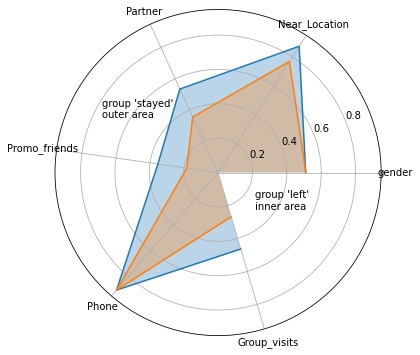

In [11]:
churn_mean = gym_churn.groupby('Churn').mean()[['gender','Near_Location','Partner','Promo_friends','Phone','Group_visits']].T

plt.figure(figsize=(6, 6))
plt.polar(churn_mean)

# Fill area
for col in churn_mean.columns:
    plt.fill_between(churn_mean.index, churn_mean[col], 0, alpha=0.3)


plt.text(5.5, 0.3, "group 'left'\ninner area")
plt.text(2.7, 0.75, "group 'stayed'\nouter area")

plt.show()

#### Heatmap of correlation matrix:

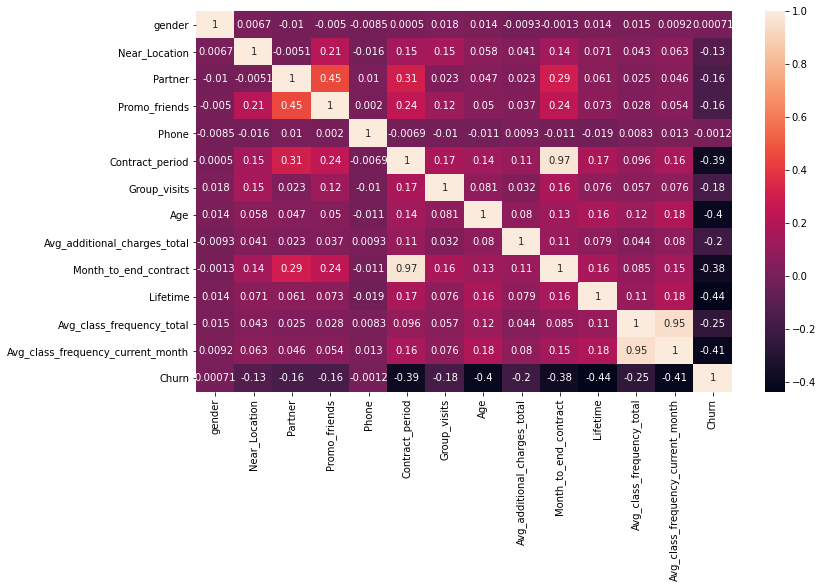

In [12]:
plt.figure(figsize=(12, 7))
sns.heatmap(gym_churn.corr(), annot=True)
plt.show()

we can see strong correlation between:
* 'Contract_period' and 'Month_to_end_contract'
* 'Avg_class_frequency_total' and 'Avg_class_frequency_current_month'

To fix multicollinearity we should remove one of the correlated features in each pair

But before that let's recheck the multicollinearity and calculate the Variance Inflation Factor (VIF)

VIF tells us about how well an independent variable is predictable using the other independent variables. 

In [13]:
# Import library for VIF
from statsmodels.stats.outliers_influence import variance_inflation_factor

# function to calculate the Variance Inflation Factor
def calc_vif(X):

    # Calculating VIF
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

    return(vif)

In [14]:
vif_df = calc_vif(gym_churn)
vif_df.sort_values('VIF', ascending=False)

,variables,VIF
11,Avg_class_frequency_total,70.208414
12,Avg_class_frequency_current_month,63.967246
5,Contract_period,39.547587
9,Month_to_end_contract,38.953600
7,Age,21.903903
4,Phone,9.555737
1,Near_Location,6.843544
8,Avg_additional_charges_total,3.404374
2,Partner,2.628084
13,Churn,2.570241


In [15]:
# drop: 'Month_to_end_contract' and 'Avg_class_frequency_total'

gym_churn.drop(['Month_to_end_contract','Avg_class_frequency_total'], axis=1, inplace=True)

In [16]:
# check results
vif_df = calc_vif(gym_churn)
vif_df.sort_values('VIF', ascending=False)

,variables,VIF
7,Age,21.724746
4,Phone,9.553282
1,Near_Location,6.842750
10,Avg_class_frequency_current_month,4.483662
8,Avg_additional_charges_total,3.401734
5,Contract_period,2.682700
2,Partner,2.624968
9,Lifetime,2.415084
0,gender,2.033014
3,Promo_friends,1.957832


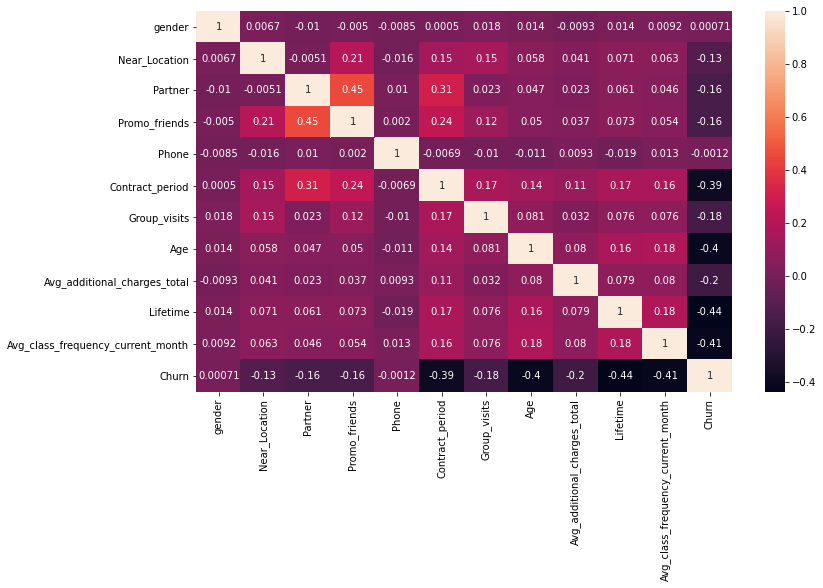

In [17]:
# check results
plt.figure(figsize=(12, 7))
sns.heatmap(gym_churn.corr(), annot=True)
plt.show()

* we got basic statistics of data
* we compared the groups 'left' vs 'stayed' by churn and got basic characteristics
* we fixed multicollinearity

## 4. Building a model to predict user churn <a id='4'></a>
[Back to top](#top)

#### Building a binary classification model for customers

In [18]:
# dividing the data into features (the X matrix) and a target variable (y)
X = gym_churn.drop('Churn', axis=1)
y = gym_churn['Churn']

# dividing the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# defining the function that will output our metrics
def print_all_metrics(y_true, y_pred, title = 'Classification metrics'):
    print(title)
    print('\tAccuracy: {:.2f}'.format(accuracy_score(y_true, y_pred)))
    print('\tPrecision: {:.2f}'.format(precision_score(y_true, y_pred)))
    print('\tRecall: {:.2f}'.format(recall_score(y_true, y_pred)))

# train StandardScaler on the train set
scaler = StandardScaler()
scaler.fit(X_train)

# transform train and test sets
X_train_st = scaler.transform(X_train)
X_test_st = scaler.transform(X_test)

# define the algorithm for the logistic regression model
lr_model = LogisticRegression(random_state=0)

# train the model
lr_model.fit(X_train_st, y_train)

# use the trained model to make predictions
lr_predictions = lr_model.predict(X_test_st)
lr_probabilities = lr_model.predict_proba(X_test_st)[:,1] #, lr_probabilities 

# print all metrics
print_all_metrics(y_test, lr_predictions, title='\nMetrics for logistic regression:')


# define the algorithm for the new random forest model
rf_model = RandomForestClassifier(n_estimators = 100, random_state=0) # 

# train the random forest model
rf_model.fit(X_train_st, y_train)

# use the trained model to make predictions
rf_predictions = rf_model.predict(X_test_st) # 
rf_probabilities = rf_model.predict_proba(X_test_st)[:,1]  # rf_probabilities,

# print all metrics
print_all_metrics(y_test, rf_predictions,  title = '\nMetrics for random forest:')


Metrics for logistic regression:
	Accuracy: 0.90
	Precision: 0.79
	Recall: 0.82

Metrics for random forest:
	Accuracy: 0.90
	Precision: 0.81
	Recall: 0.75


The metrics show us that
* the model 'logistic regression' gives better results with Recall and Accuracy
* the model 'random forest' gives same results with Precision

#### The factors that impact churn most
We will use the permutation_importance function that calculates the feature importance of estimators for a given dataset.

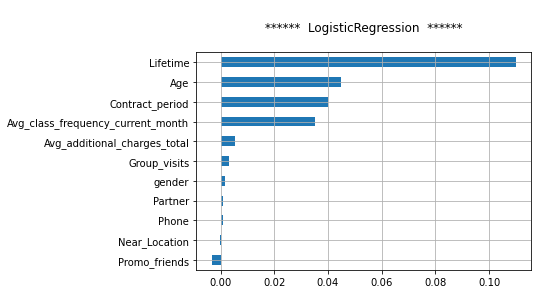

,importances_mean,importances_std
Lifetime,0.109958,0.010525
Age,0.044708,0.008664
Contract_period,0.039833,0.006138
Avg_class_frequency_current_month,0.035208,0.007094
Avg_additional_charges_total,0.005292,0.006256
Group_visits,0.003042,0.003546
gender,0.001500,0.001225
Partner,0.001042,0.002307
Phone,0.000708,0.001004
Near_Location,-0.000250,0.001384


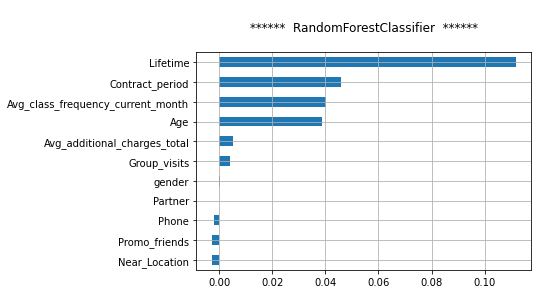

,importances_mean,importances_std
Lifetime,0.111750,0.011094
Contract_period,0.045875,0.005829
Avg_class_frequency_current_month,0.040333,0.006661
Age,0.038750,0.008335
Avg_additional_charges_total,0.005292,0.005680
Group_visits,0.004042,0.003334
gender,0.000375,0.001913
Partner,-0.000083,0.002640
Phone,-0.001792,0.001758
Promo_friends,-0.002625,0.002688


In [19]:
# dictionary of models
models = {'LogisticRegression':lr_model, 'RandomForestClassifier':rf_model}

# calculating the feature importance
for k, model in models.items():
    result = permutation_importance(model, X_test_st, y_test, n_repeats=30, random_state=0)

    result_df = pd.DataFrame({"importances_mean":result["importances_mean"], 
                              "importances_std":result["importances_std"]}, 
                             index=X.columns)

#     plt.figure(figsize=(8, 5))
    plt.title(f'\n******  {k}  ******\n')
    result_df.sort_values("importances_mean").importances_mean.plot.barh(grid=True)
    plt.show()
    display(result_df.sort_values("importances_mean", ascending=False))

Both models say that the factors that impact churn most are:
* Lifetime
* Age
* Contract_period
* Avg_class_frequency_current_month

## 5. Creating user clusters <a id='5'></a>
[Back to top](#top)

#### Standardization of data

In [20]:
# the standardization of data
X_st = scaler.fit_transform(X)

#### Hierarchical clustering

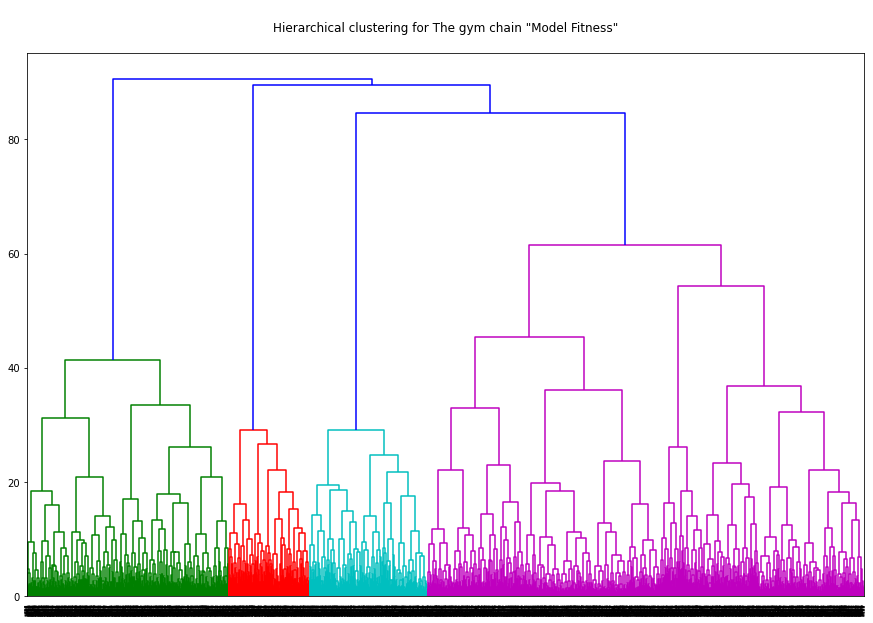

In [21]:
linked = linkage(X_st, method = 'ward')

# The variable linked stores the table with the linked bundles of objects. It can be visualized as a dendrogram:

plt.figure(figsize=(15, 10))  

dendrogram(linked, orientation='top')
plt.title('\nHierarchical clustering for The gym chain "Model Fitness"\n')
plt.show()

Hierarchical clustering using 'scipy.cluster.hierarchy.linkage' algorithm with method 'ward' gives 4 clusters

#### Choosing the Appropriate Number of Clusters with the k-means method 

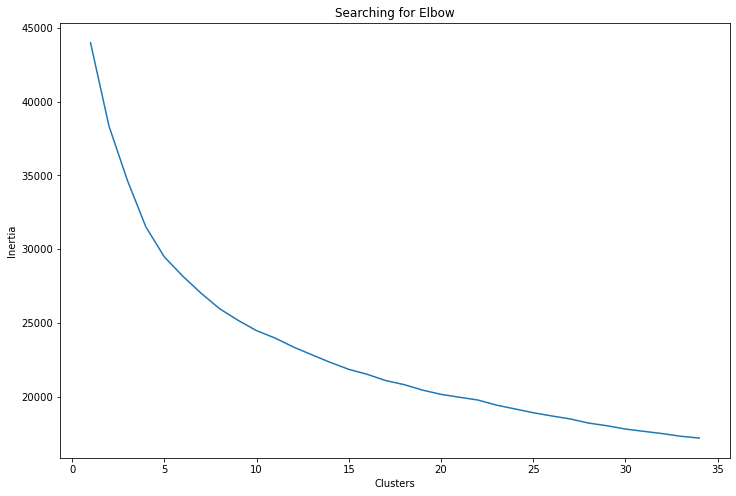

In [22]:
# from sklearn.cluster import KMeans

clusters = []

for i in range(1, 35):
    km = KMeans(n_clusters=i, random_state=0).fit(X_st)
    clusters.append(km.inertia_)
    
fig, ax = plt.subplots(figsize=(12, 8))
sns.lineplot(x=list(range(1, 35)), y=clusters, ax=ax)
ax.set_title('Searching for Elbow')
ax.set_xlabel('Clusters')
ax.set_ylabel('Inertia')

# Annotate Possible Elbow Point
# ax.text(7.5, 35000, 'Possible Elbow Point at 5 clusters seems to be appropriate')


plt.show()

5 clusters seem to be appropriate number

#### Applying the algorithm to the data and forming a cluster vector

In [23]:
km = KMeans(n_clusters = 5, random_state=0) # setting the number of clusters as 5
labels = km.fit_predict(X_st) # applying the algorithm to the data and forming a cluster vector

In [24]:
# adding column ['cluster_km'] to the dataframe

gym_churn['cluster_km'] = labels

gym_churn.head()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Lifetime,Avg_class_frequency_current_month,Churn,cluster_km
0,1,1,1,1,0,6,1,29,14.227470,3,0.000000,0,2
1,0,1,0,0,1,12,1,31,113.202938,7,1.910244,0,4
2,0,1,1,0,1,1,0,28,129.448479,2,1.736502,0,0
3,0,1,1,1,1,12,1,33,62.669863,2,3.357215,0,1
4,1,1,1,1,1,1,0,26,198.362265,3,1.120078,0,1


#### The mean feature values for clusters

In [25]:
gym_churn_group_mean = gym_churn.groupby('cluster_km').mean()
gym_churn_group_mean.T

cluster_km,0,1,2,3,4
gender,0.490654,0.495943,0.523316,0.500000,0.546000
Near_Location,1.000000,0.995943,0.862694,0.000000,0.996000
Partner,0.217757,0.891481,0.471503,0.489247,0.380000
Promo_friends,0.070093,1.000000,0.305699,0.078853,0.011000
Phone,1.000000,1.000000,0.000000,1.000000,1.000000
Contract_period,2.047664,6.911765,4.777202,2.994624,6.204000
Group_visits,0.289720,0.523327,0.427461,0.232975,0.528000
Age,27.673832,29.601420,29.297927,28.679211,30.627000
Avg_additional_charges_total,117.271746,153.355426,144.208179,137.125763,178.905160
Lifetime,1.935514,4.281947,3.940415,2.974910,5.425000


clusters by 'non-binary' features:
* Contract_period: 
    * #0 min
    * #1 max                    
* Age:
    * #0 min
    * #4 max                   
* Avg_additional_charges_total:
    * #0 min
    * #4 max
* Lifetime:
    * #0 min
    * #4 max   
* Avg_class_frequency_current_month:
    * #0 min
    * #4 max

#### Churn rate by clusters

In [26]:
gym_churn_group_mean[['Churn']].sort_values('Churn')

,Churn
cluster_km,
4,0.017000
1,0.119675
2,0.266839
3,0.403226
0,0.558879


* cluster #4 has the minimum churn
* cluster #0 has the maximum churn

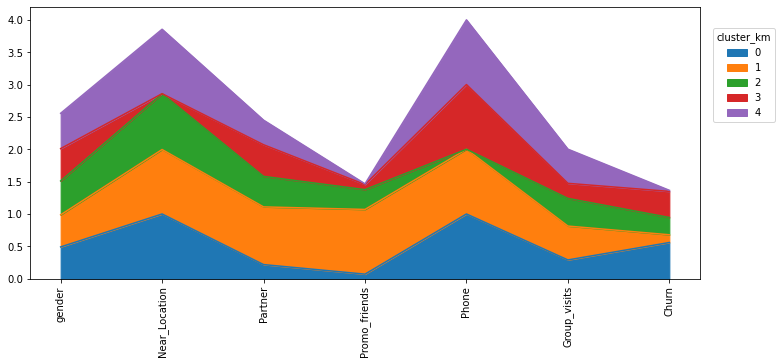

In [27]:
binary_feat = gym_churn_group_mean[['gender','Near_Location','Partner','Promo_friends','Phone','Group_visits','Churn']].T

# binary_feat.plot(kind='line', figsize=(12, 5), linewidth=5, figsize=(12, 5), rot=90)
binary_feat.plot(kind='area', figsize=(12, 5), rot=90)

plt.legend(loc='center right', bbox_to_anchor=(1.12, .75), ncol=1, title='cluster_km')
plt.xticks(range(len(binary_feat.index)), binary_feat.index)
plt.show()

clusters by 'binary' features:

* 'gender': similar
* 'Near_Location': cluster #3 is not in Near Location
* 'Partner': cluster #1 is most active
* 'Promo_friends': cluster #1 is most active
* 'Phone': cluster #2 no phone
* 'Group_visits': clusters #1 and #4 more active
* 'Churn': 
    * cluster #4 has the minimum churn
    * cluster #0 has the maximum churn

#### Feature distributions by clusters

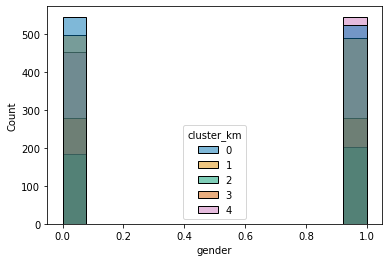

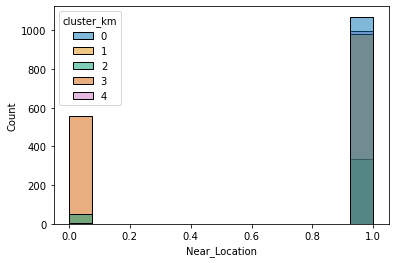

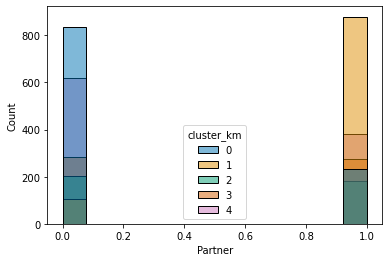

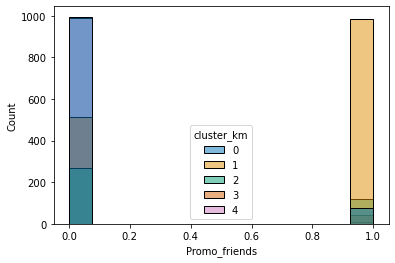

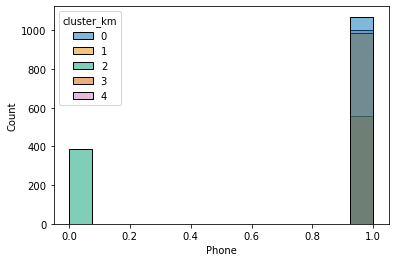

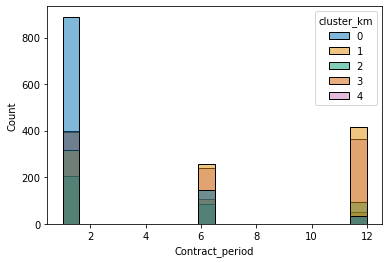

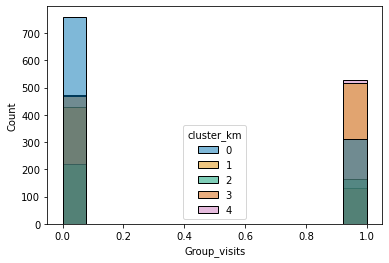

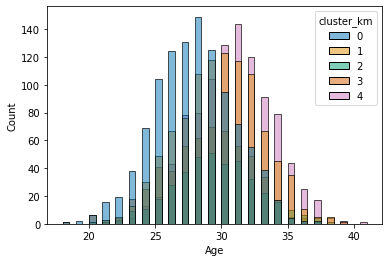

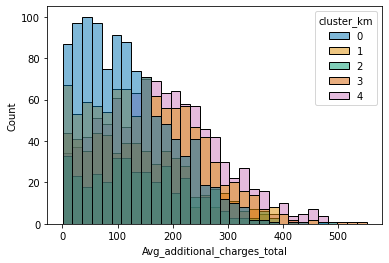

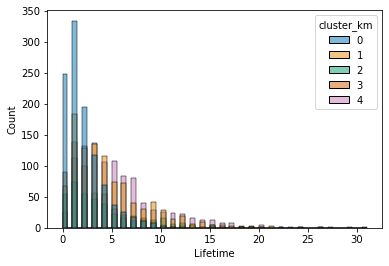

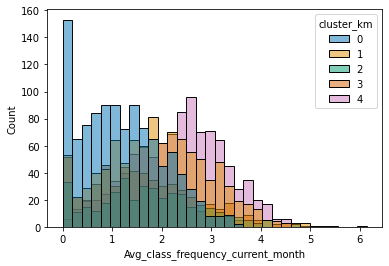

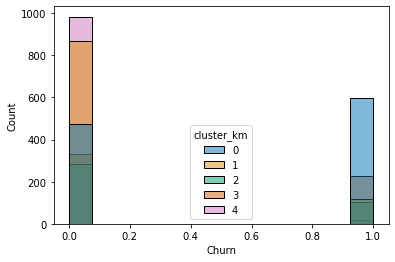

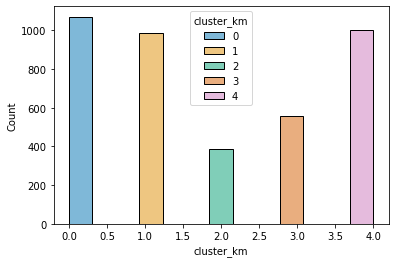

In [28]:
for col in gym_churn.columns:
    sns.histplot(data=gym_churn, x=col, hue='cluster_km', palette='colorblind')
#     sns.histplot(data=gym_churn, x=col, hue='Churn', palette='colorblind')
    plt.show()

In [29]:
# finding most 'changeable' features

gym_churn.groupby('cluster_km').mean().T.std(1).sort_values(ascending=False)

Avg_additional_charges_total         22.605182
Contract_period                       2.063934
Lifetime                              1.323875
Age                                   1.095965
Phone                                 0.447214
Near_Location                         0.434889
Avg_class_frequency_current_month     0.429670
Promo_friends                         0.410816
Partner                               0.248870
Churn                                 0.216661
Group_visits                          0.134542
gender                                0.023120
dtype: float64

#### Most changeable features by churn and clusters

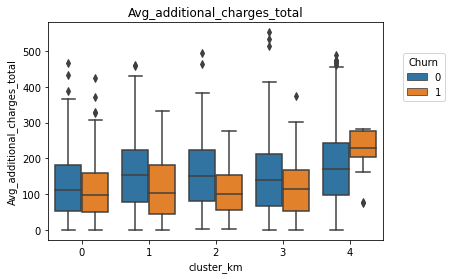

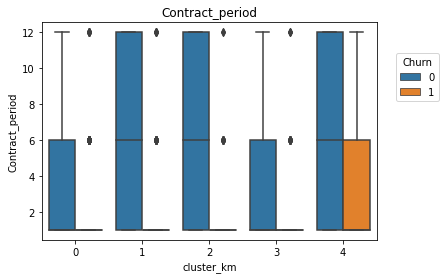

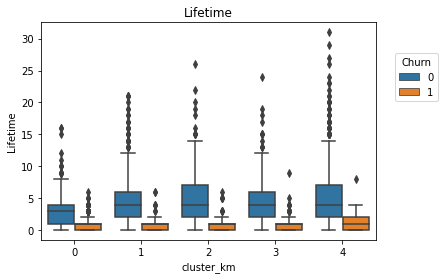

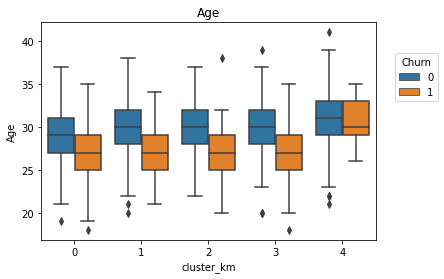

In [30]:
# list of most changeable features
cols = ['Avg_additional_charges_total', 'Contract_period', 'Lifetime', 'Age']

for i in cols:
#     ax = sns.boxplot(x='cluster_km', y=i, hue='Contract_period', data=gym_churn)
    ax = sns.boxplot(x='cluster_km', y=i, hue='Churn', data=gym_churn)
#     ax.legend(loc='center right', bbox_to_anchor=(1.3, .75), ncol=1, title='Contract_period')
    ax.legend(loc='center right', bbox_to_anchor=(1.2, .75), ncol=1, title='Churn')
    plt.title(i)
    plt.show()
 

The graphs above show a significant difference of the group 'left' (churn = 1) in cluster #4

Note: cluster #4 has the minimum churn 

## 6. Conclusion. <a id='6'></a>
[Back to top](#top)

#### Our tasks were:
* to predict the probability of churn for each customer
* to analyze the factors that impact churn most
* to draw up typical user portraits



#### We trained the models 'logistic regression' and 'random forest', evaluated the quality of models' predictions and got appropriate results:
* Accuracy: 0.90
* Precision: 0.81
* Recall: 0.82

#### We analyzed the factors that impact churn most:
* Age
* Lifetime
* Contract_period
* Avg_class_frequency_current_month

#### We defined typical characteristics of the group 'left':
* younger
* living farther
* less active
* with significantly shorter Contract period

### The main question is what can we do to decrease churn?
#### Based on results of our calculations we can:
* define the target group
* promote contract renewals in advance
* offer a discount to newcomers
* involve customers into activities such as 'Partner', 'Promo friends', 'Group visits'

Above we have already mentioned some of the steps to reduce churn, in addition we could focus on getting regular feedback, including customer satisfaction surveys
    
this can provide the necessary information that allows us:
* to understand the reasons why customers are leaving
* what can we improve
* to act proactively

some more examples:
* one week free trial
* branded t-shirt for every new customer 
* upon contract renewal one-time discount